# Buidling Causal Graphical Models

Reminder that we're using tools to infer what the data generating process (DGP) may look like. One set of data may imply many different DGPs, so it's a hard game to play. This chapter is focused on graphically representing the DGP.

## 3.1.1 Transportation Case Study

In [1]:
# 3.2 Building the transportation DAG in pgmpy

from pgmpy.models import DiscreteBayesianNetwork
model = DiscreteBayesianNetwork(
    [
        ('Age', 'Education'),
        ('Gender', 'Education'),
        ('Education', 'Occupation'),
        ('Education', 'Residence'),
        ('Occupation', 'Transportation'),
        ('Residence', 'Transportation')
    ]
)

model

## 3.1.3 DAGs as Communication Tools

- Examples in which you've used DAGs for communication
- Discuss DAG limitations as a reminder
    - "How" vs "What"
- Logic Gates visualize "How"
    

DAGs represent and codify causal assumptions that can be used in further computation purposes. they also represent time, in that the causal arrow assumes forward movement in time. 

Identified ways of getting around the "acyclic" assumption in DAGs without necessarily having to relax the criteria. Example given is to unpack the "cycles" into discrete steps and track their path over time. 

## Linking Causality to Conditional Independence

Highlighted how causal DAG allows a much simpler structure for formulating joint probability, because the causal pathway carries some assumptions about conditional independence.

Specifically, in the geneology example, the author demonstrates where the 2 parents' blood types contain enough info to explain a child's blood type without knowing the parents' blood type.

This characteristic, where direct "parent" properties supercede "grandparent" properties, is called the "causal Markov property"



## Scaffolding for Causal Machine Learning Models

Building with the DAG as the scaffolding permits the further goal - building causal machine learning models. These can be used for prediction and causal inference.

After factoring under the assumption of causal conditional indepdence, the "factors" are also called Markov Kernels



### Labeling Causal Abstractions

Labels are by their nature fluid and changing, so it's important to be careful about consistency among labels. Author citied the example of race, whose definition has definitely changed over time.

"In machine learning, we're often encouraged to blindly label data and not think about the DGP"



## Training a Model on a Causal Dag

In [2]:
import polars as pl
url = 'https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv'
df = pl.read_csv(url)
df.columns = ["Age", "Gender", "Education", "Occupation", "Residence", "Transportation"]

In [3]:
# There are people in this world who use data without looking at it. Don't let it be you!
# in notebooks, "sample" can give you a better idea what's in a dataframe than "head"

df.sample(10)

Age,Gender,Education,Occupation,Residence,Transportation
str,str,str,str,str,str
"""young""","""M""","""high""","""emp""","""big""","""car"""
"""old""","""M""","""uni""","""emp""","""big""","""car"""
"""young""","""F""","""uni""","""emp""","""big""","""other"""
"""young""","""M""","""high""","""emp""","""small""","""car"""
"""young""","""M""","""high""","""emp""","""small""","""car"""
"""adult""","""M""","""high""","""emp""","""big""","""car"""
"""adult""","""M""","""high""","""emp""","""big""","""car"""
"""adult""","""F""","""uni""","""emp""","""big""","""car"""
"""young""","""M""","""high""","""emp""","""big""","""car"""


In [4]:
# Learning Parameters for the causal Markov kernels
model.fit(df.to_pandas())  # polars wins on convenience, pandas wins on compatibility
causal_markov_kernels = model.get_cpds()
print(causal_markov_kernels)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'Education': 'C', 'Occupation': 'C', 'Residence': 'C', 'Transportation': 'C'}


[<TabularCPD representing P(Age:3) at 0x17b913bf0>, <TabularCPD representing P(Education:2 | Age:3, Gender:2) at 0x17b5d3560>, <TabularCPD representing P(Gender:2) at 0x1766a30b0>, <TabularCPD representing P(Occupation:2 | Education:2) at 0x176e64740>, <TabularCPD representing P(Residence:2 | Education:2) at 0x17b39e540>, <TabularCPD representing P(Transportation:3 | Occupation:2, Residence:2) at 0x17af99220>]


In [5]:
cmk_T_max_likelihood = causal_markov_kernels[-1]
cmk_T_max_likelihood.to_dataframe().T  # this is MUCH better than print(cmk_T)

Occupation           emp                self      
Residence            big     small       big small
Transportation                                    
car             0.703431  0.524390  0.444444   1.0
other           0.134804  0.085366  0.333333   0.0
train           0.161765  0.390244  0.222222   0.0

### Different Techniques for Parameter Learning

"Maximum Likelihood" seeks the parameter that maximizes the likelihood of seeing the data we use to train the model. For categorical data, this is a matter of proportions of the seen data

Dirichilet conjugate priors allow us to calculate distributions using only simple math. This is embedded in pgmpy

In [6]:
from pgmpy.estimators import BayesianEstimator

model.fit(
    df.to_pandas(),
    estimator=BayesianEstimator,
    prior_type="dirichlet",
    pseudo_counts=1  # the parameters of the Dirichlet prior
)

causal_markov_kernels = model.get_cpds()  # extract causal markov kernels - conditional probability distributions
cmk_T_bayesian = causal_markov_kernels[-1]  # We're after probability of Transportation type given Occupation and Residence
cmk_T_bayesian.to_dataframe().T  # Again, this transpose view mirrors what you see in the book, but as a df rather than string

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Age': 'C', 'Gender': 'C', 'Education': 'C', 'Occupation': 'C', 'Residence': 'C', 'Transportation': 'C'}


Occupation           emp                self      
Residence            big     small       big small
Transportation                                    
car             0.700730  0.517647  0.416667  0.50
other           0.136253  0.094118  0.333333  0.25
train           0.163017  0.388235  0.250000  0.25

In [7]:
# Bayesians and Frequentists can argue here

print("Max Likelihood Estimation Approach") 
print("Recall from page 83 that this is looking at proportions as they appear in the data")
print(cmk_T_max_likelihood.to_dataframe().T)
print("\nBayesian Estimation Approach")
print("Recall from page 84 that this approach uses a prior distribution, which helps avoid extremes such as the MLE approach saying that all entrepreneurs in small cities use cars (rightmost column)")
print(cmk_T_bayesian.to_dataframe().T)


Max Likelihood Estimation Approach
Recall from page 83 that this is looking at proportions as they appear in the data
Occupation           emp                self      
Residence            big     small       big small
Transportation                                    
car             0.703431  0.524390  0.444444   1.0
other           0.134804  0.085366  0.333333   0.0
train           0.161765  0.390244  0.222222   0.0

Bayesian Estimation Approach
Recall from page 84 that this approach uses a prior distribution, which helps avoid extremes such as the MLE approach saying that all entrepreneurs in small cities use cars (rightmost column)
Occupation           emp                self      
Residence            big     small       big small
Transportation                                    
car             0.700730  0.517647  0.416667  0.50
other           0.136253  0.094118  0.333333  0.25
train           0.163017  0.388235  0.250000  0.25


### Other Techniques for Paramter Estimation

Author reminds us that the DAG exists totally separate from the algorithms and methods we use to estimate the causal impact. So whether age is calculated in seconds or days, or whether we use a neural net or logistic regression to model our assumptions is separate from the DAG itself

### Latent Variables

Remember that we are searching to understand a data generating process (DGP), not necessarily report on data. Data, then are clues and context about what the DGP may be. 

This means we have to give consideration to "latent variables" which are characteristics not directly observed in the data but inferrable from the data.

In [8]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ExpectationMaximization as EM
url = "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/transportation_survey.csv"
data = pl.read_csv(url)
data_sans_E = data.drop("E")

In [9]:
model_with_latent = DiscreteBayesianNetwork(
    [
        ('A', 'E'),
        ('S', 'E'),
        ('E', 'O'),
        ('E', 'R'),
        ('O', 'T'),
        ('R', 'T')
    ],
    latents={"E"}  # We're running the structural expectation maximization algorithm, so we have to tell pgmpy which variable is latent
)

estimator = EM(model_with_latent, data_sans_E.to_pandas())

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'C', 'S': 'C', 'O': 'C', 'R': 'C', 'T': 'C'}


In [10]:
cmks_with_latent = estimator.get_parameters(latent_card={"E": 2})
cmks_with_latent

  0%|          | 0/100 [00:00<?, ?it/s]

[<TabularCPD representing P(S:2) at 0x17d91e630>,
 <TabularCPD representing P(T:3 | O:2, R:2) at 0x17db275f0>,
 <TabularCPD representing P(A:3) at 0x17d8f6f00>,
 <TabularCPD representing P(R:2 | E:2) at 0x17db7b410>,
 <TabularCPD representing P(O:2 | E:2) at 0x177cabc50>,
 <TabularCPD representing P(E:2 | A:3, S:2) at 0x17db272f0>]

In [11]:
cmks_with_latent[1].to_factor()  # this is the index position called in the book, but it's not representing the latent variable we were looking for

<DiscreteFactor representing phi(T:3, O:2, R:2) at 0x17b5a0770>

In [12]:
# Further inference is needed to determine what 0 and 1 mean, but at a high level, interesting how it maps
# latent expectations for these arbitrary "categories" given data that it didn't observe

# In actual practice, we would test performance on known data to try to get an idea of
# error before practical use and decision making

print(cmks_with_latent[5].to_factor())

+------+----------+------+--------------+
| E    | A        | S    |   phi(E,A,S) |
+======+==========+======+==============+
| E(0) | A(adult) | S(F) |       0.4846 |
+------+----------+------+--------------+
| E(0) | A(adult) | S(M) |       0.4165 |
+------+----------+------+--------------+
| E(0) | A(old)   | S(F) |       0.6799 |
+------+----------+------+--------------+
| E(0) | A(old)   | S(M) |       0.9255 |
+------+----------+------+--------------+
| E(0) | A(young) | S(F) |       0.0958 |
+------+----------+------+--------------+
| E(0) | A(young) | S(M) |       0.6619 |
+------+----------+------+--------------+
| E(1) | A(adult) | S(F) |       0.5154 |
+------+----------+------+--------------+
| E(1) | A(adult) | S(M) |       0.5835 |
+------+----------+------+--------------+
| E(1) | A(old)   | S(F) |       0.3201 |
+------+----------+------+--------------+
| E(1) | A(old)   | S(M) |       0.0745 |
+------+----------+------+--------------+
| E(1) | A(young) | S(F) |       0

### Inference on a Trained Causal Graphical Model

In [13]:
from pgmpy.inference import VariableElimination

In [14]:
inference = VariableElimination(model)

In [15]:
# Remember that I wrote these in English earlier
query1 = inference.query(["Education"], evidence={"Transportation": "train"})
query2 = inference.query(["Education"], evidence={"Transportation": "car"})

In [16]:
print("train")
print(query1)
print("\ncar")
print(query2)

train
+-----------------+------------------+
| Education       |   phi(Education) |
+=================+==================+
| Education(high) |           0.6162 |
+-----------------+------------------+
| Education(uni)  |           0.3838 |
+-----------------+------------------+

car
+-----------------+------------------+
| Education       |   phi(Education) |
+=================+==================+
| Education(high) |           0.5586 |
+-----------------+------------------+
| Education(uni)  |           0.4414 |
+-----------------+------------------+


#### Pyro Implementation

In [17]:
import torch
import pyro
from pyro.distributions import Categorical

In [18]:
# forming integer mappings because pyro's only returns numbers
A_alias = ["young", "adult", "old"]
S_alias = ["M", "F"]
E_alias = ["high", "uni"]
O_alias = ["emp", "self"]
R_alias = ["small", "big"]
T_alias = ["car", "train", "other"]

In [19]:
# probabilities defined as in the book
A_prob = torch.tensor([0.3,0.5,0.2])
S_prob = torch.tensor([0.6,0.4])
E_prob = torch.tensor([[[0.75,0.25], [0.72,0.28], [0.88,0.12]],
                     [[0.64,0.36], [0.7,0.3], [0.9,0.1]]])
O_prob = torch.tensor([[0.96,0.04], [0.92,0.08]])
R_prob = torch.tensor([[0.25,0.75], [0.2,0.8]])
T_prob = torch.tensor([[[0.48,0.42,0.1], [0.56,0.36,0.08]],
                     [[0.58,0.24,0.18], [0.7,0.21,0.09]]])

In [20]:
def model():
    A = pyro.sample('age', Categorical(probs=A_prob))
    S = pyro.sample('gender', Categorical(probs=S_prob))
    E = pyro.sample('education', Categorical(probs=E_prob[S][A]))
    O = pyro.sample('occupation', Categorical(probs=O_prob[E]))
    R = pyro.sample('residence', Categorical(probs=R_prob[E]))
    T = pyro.sample('transportation', Categorical(probs=T_prob[R][O]))
    return {'A': A, 'S': S, 'E': E, 'O': O, 'R': R, 'T': T}

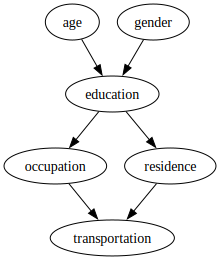

In [21]:
pyro.render_model(model)

In [24]:
from dowhy import datasets
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px

In [27]:
sim_data = datasets.linear_dataset(
    beta=10.0,
    num_treatments=1,
    num_instruments=2,
    num_effect_modifiers=2,
    num_common_causes=5,
    num_frontdoor_variables=1,
    num_samples=100
)

sim_data.keys()

dict_keys(['df', 'treatment_name', 'outcome_name', 'common_causes_names', 'instrument_names', 'effect_modifier_names', 'frontdoor_variables_names', 'dot_graph', 'gml_graph', 'ate'])

In [28]:
sim_data['df']

,FD0,X0,X1,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.702602,-0.076597,1.503810,1.0,0.927995,-0.082790,-1.849508,1.183834,0.576887,-0.450739,True,0.785463
1,4.252994,-0.747033,-0.497630,1.0,0.456240,0.541403,1.168405,0.696132,2.511974,0.540265,True,30.822510
2,3.868259,1.503360,1.943528,1.0,0.474940,0.284533,0.654857,1.300567,0.748340,0.736040,True,22.046397
3,3.496398,-1.090537,0.596136,1.0,0.116552,-0.403838,-0.473396,-0.206385,1.828164,1.949830,True,18.044230
4,1.693561,-0.020754,0.503363,1.0,0.367555,-2.787475,-0.249084,-0.447819,-0.324294,-0.093627,True,-10.249713
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.508625,-1.067826,0.021713,0.0,0.167321,-1.199767,0.431684,1.304820,1.025550,-0.002158,False,3.410364
96,3.501812,0.194637,1.070434,0.0,0.794992,-0.020572,-1.507942,0.774454,0.688353,0.361827,True,9.465965
97,3.591089,1.191190,-0.431227,1.0,0.011776,1.209786,1.736560,-0.445751,0.769504,0.436795,True,25.814945
98,6.743776,1.002964,-0.642032,1.0,0.547920,0.715261,-0.635860,1.192151,0.427559,1.642949,True,28.195424


In [30]:
sim_data['frontdoor_variables_names']

['FD0']

In [31]:
sim_data['dot_graph']

'digraph {W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;v0-> FD0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y; X1-> y;FD0-> y;}W0-> FD0;W1-> FD0;W2-> FD0;W3-> FD0;W4-> FD0;'

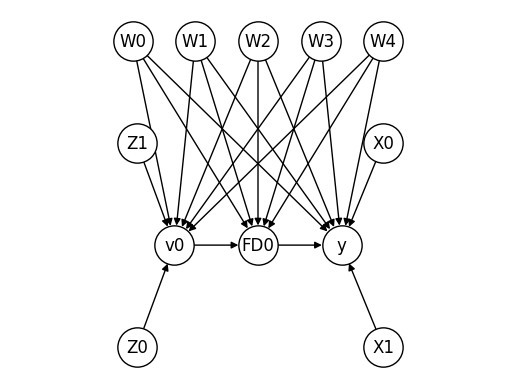

In [33]:
dag = nx.parse_gml(sim_data['gml_graph'])
pos = {
    'X0': (600, 350),
    'X1': (600, 250),
    'FD0': (300, 300),
    'W0': (0, 400),
    'W1': (150, 400),
    'W2': (300, 400),
    'W3': (450, 400),
    'W4': (600, 400),
    'Z0': (10, 250),
    'Z1': (10, 350),
    'v0': (100, 300),
    'y': (500, 300)
}

options = {
    "font_size": 12,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1
}

nx.draw_networkx(dag, pos, **options)
ax = plt.gca()
ax.margins(x=0.40)
plt.axis("off")
plt.show()